In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

from copy import deepcopy
from tqdm import tqdm

np.random.seed(42)
random_state = np.random.get_state()

In [2]:
# A wrapper class for a maze, containing all the information about the maze.
class Maze:
    def __init__(self):
        # maze width, height
        self.WORLD_WIDTH = 9
        self.WORLD_HEIGHT = 6

        # all possible actions
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]

        # start, goal state
        self.START_STATE = [2, 0]
        self.GOAL_STATES = [[0, 8]]

        # all obstacles
        self.obstacles = [
            [1, 2], [2, 2], [3, 2],
            [0, 7], [1, 7], [2, 7],
            [4, 5]]

        # the size fo q value
        self.q_size = (self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions))

        # max steps
        self.max_steps = float('inf')

    # take @action in @state
    # @return: [reward, new state]
    def step(self, state, action):
        y, x = state
        if action == self.ACTION_UP:
            y = max(y - 1, 0)
        elif action == self.ACTION_DOWN:
            y = min(y + 1, self.WORLD_HEIGHT - 1)
        elif action == self.ACTION_LEFT:
            x = max(x - 1, 0)
        elif action == self.ACTION_RIGHT:
            x = min(x + 1, self.WORLD_WIDTH - 1)
        
        if [y, x] in self.obstacles:
            y, x = state
        if [y, x] in self.GOAL_STATES:
            reward = 1.0
        else:
            reward = 0.0
        
        return reward, [y, x]

In [3]:
# a wrapper class for parameters of dyna algorithms
class DynaParams:
    def __init__(self):
        # discount
        self.gamma = 0.95
        
        # probability for exploration
        self.epsilon = 0.1

        # step size
        self.alpha = 0.1

        # n-step planning
        self.planning_steps = 5

        # average over several independent runs
        self.runs = 10

In [4]:
# Trivial model for planning in Dyna-Q
class TrivialModel:
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, rand=np.random):
        self.model = dict()
        self.rand = rand
    
    # feed the model with previous experience
    def feed(self, state, action, reward, next_state):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [reward, list(next_state)]
    
    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        reward, next_state = self.model[state][action]

        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return list(state), action, reward, list(next_state)

In [5]:
# choose an action based on epsilon-greedy algorithm
def choose_action(state, q_value, maze, dyna_params):
    if np.random.binomial(1, dyna_params.epsilon) == 1:
        return np.random.choice(maze.actions)
    else:
        values = q_value[state[0], state[1], :]
        return np.random.choice(np.argwhere(np.max(values) == values).flatten())

In [6]:
def show_maze(maze, _from, to):
    world = np.chararray((maze.WORLD_HEIGHT, maze.WORLD_WIDTH), unicode=True)
    world[:] = " "

    start = maze.START_STATE
    world[start[0], start[1]] = "S"
    for goal in maze.GOAL_STATES:
        world[goal[0], goal[1]] = "G"
    for obstacle in maze.obstacles:
        world[obstacle[0], obstacle[1]] = "X"
    
    world[_from[0], _from[1]] = "F"
    print(to)
    world[to[0], to[1]] = "T"

    print(world)
    print()  


In [7]:
# play for an episode for Dyna-Q algorithm
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def dyna_q(q_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0

    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)

        # take action
        reward, next_state = maze.step(state, action)

        # Q-Learning update
        q_value[state[0], state[1], action] = q_value[state[0], state[1], action] + dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) - q_value[state[0], state[1], action])

        # feed the model with experience
        model.feed(state, action, reward, next_state)

        # sample experience from the model
        for t in range(0, dyna_params.planning_steps):
            state_, action_, reward_, next_state_ = model.sample()
            q_value[state_[0], state_[1], action_] = q_value[state_[0], state_[1], action_] + dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) - q_value[state_[0], state_[1], action_])
        
        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break
    
    return steps

In [8]:
# Figure 8.2, DynaMaze, use 10 runs instead of 30 runs
def figure_8_2():
    # set up a instance for DynaMaze
    dyna_maze = Maze()
    dyna_params = DynaParams()

    runs = 30
    episodes = 50
    planning_steps = [0, 5, 50]
    steps = np.zeros((len(planning_steps), episodes))

    for run in tqdm(range(runs)):
        np.random.set_state(random_state)

        for i, planning_step in enumerate(planning_steps):
            dyna_params.planning_steps = planning_step
            q_value = np.zeros(dyna_maze.q_size)

            # generate an instance of Dyna-Q model
            model = TrivialModel()
            for ep in range(episodes):
                steps[i, ep] += dyna_q(q_value, model, dyna_maze, dyna_params)
    
    # averaging over runs
    steps /= runs

    for i in range(len(planning_steps)):
        plt.plot(steps[i, :], label="{:d} planning steps".format(planning_steps[i]))
    plt.xlabel("episodes")
    plt.ylabel("steps per episode")
    plt.legend()
    plt.show()

100%|██████████| 30/30 [06:14<00:00, 12.47s/it]


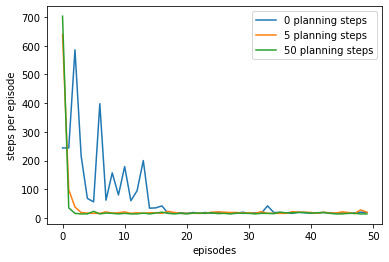

In [9]:
figure_8_2()